# 1. General Information About the dataset

In [162]:
import pandas as pd 
df = pd.read_csv('data/raw/raw_fin_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


##### note from documentation of the dataset itself:
 * Transactions which are detected as fraud are cancelled, so for fraud detection these columns (oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest ) must not be used.


In [163]:
print(df.shape)
df.drop(columns=['newbalanceDest', 'oldbalanceDest','newbalanceOrig','oldbalanceOrg','isFlaggedFraud'], inplace=True)
print(df.shape)

(6362620, 11)
(6362620, 6)
(6362620, 6)


In [164]:
df

,step,type,amount,nameOrig,nameDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1
3,1,CASH_OUT,181.00,C840083671,C38997010,1
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,C776919290,1
6362616,743,TRANSFER,6311409.28,C1529008245,C1881841831,1
6362617,743,CASH_OUT,6311409.28,C1162922333,C1365125890,1
6362618,743,TRANSFER,850002.52,C1685995037,C2080388513,1


In [165]:
print((df['isFraud'].value_counts()/df.shape[0])*100)

isFraud
0    99.870918
1     0.129082
Name: count, dtype: float64


In [166]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

In [167]:
df

,step,type,amount,nameOrig,nameDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0
2,1,TRANSFER,181.00,C1305486145,C553264065,1
3,1,CASH_OUT,181.00,C840083671,C38997010,1
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0
...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,C776919290,1
6362616,743,TRANSFER,6311409.28,C1529008245,C1881841831,1
6362617,743,CASH_OUT,6311409.28,C1162922333,C1365125890,1
6362618,743,TRANSFER,850002.52,C1685995037,C2080388513,1


# 2. Sanity checks

In [168]:
df.duplicated().sum()

np.int64(0)

In [169]:
df.isna().sum()

step        0
type        0
amount      0
nameOrig    0
nameDest    0
isFraud     0
dtype: int64

In [170]:
# the range of hours MUST NOT exceed 24
(df['step']//30)

0           0
1           0
2           0
3           0
4           0
           ..
6362615    24
6362616    24
6362617    24
6362618    24
6362619    24
Name: step, Length: 6362620, dtype: int64

In [171]:
print(df['amount'].max())
print(df['amount'].min())

92445516.64
0.0


In [172]:
df[df['amount']==0.0]['type'].value_counts()

type
CASH_OUT    16
Name: count, dtype: int64

#### This discovery sparks an investigation, and we realize such 0  amount transactions are cancelled true frauds in real-time.

In [173]:
df[(df['type']=='CASH_OUT')&(df['amount']==0.0)]['isFraud'].value_counts()

isFraud
1    16
Name: count, dtype: int64

In [174]:
before_rows=df.shape[0]
df = df[df['amount']>0.0]
after_rows=df.shape[0]
print(before_rows-after_rows)

16


In [175]:
# nameOrig and nameDest should follow the pattern: one letter followed by digits
pattern = r'^[A-Za-z]\d+$'

# boolean masks
orig_ok = df['nameOrig'].astype(str).str.strip().str.match(pattern)
dest_ok = df['nameDest'].astype(str).str.strip().str.match(pattern)

print('nameOrig invalid:', (~orig_ok).sum())
print('nameDest invalid:', (~dest_ok).sum())

display(df.loc[~orig_ok, ['nameOrig']].head(10))
display(df.loc[~dest_ok, ['nameDest']].head(10))

nameOrig invalid: 0
nameDest invalid: 0


,nameOrig


,nameDest


# 3. Correlations ?

In [176]:
print((df['nameDest'].nunique()/df.shape[0])*100)
print((df['nameOrig'].nunique()/df.shape[0])*100)

42.78686839539283
99.85362911160274
99.85362911160274


In [177]:
df['nameOrig'].nunique(), df['nameDest'].nunique()

(6353291, 2722359)

#### Origins are far too unique to meaningful correlate to any target as GROUPS. But what of destinations? 

In [178]:
df.groupby('nameDest')['isFraud'].sum().sort_values(ascending=False).head(10)

nameDest
C650699445     2
C1669818195    2
C105660024     2
C1185292292    2
C1837027614    2
C385133759     2
C185805228     2
C200064275     2
C1650668671    2
C967226405     2
Name: isFraud, dtype: int64

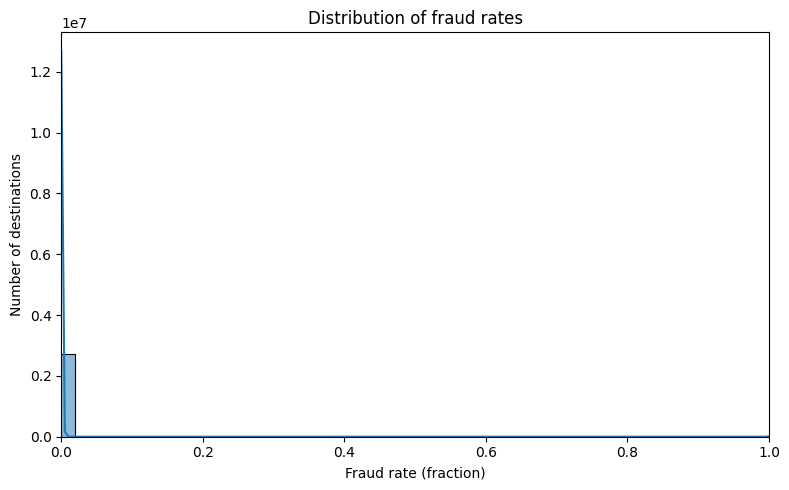

In [179]:
# That seems insigificant, but what if some of these destinations have 2 records themselves? That 
# would be a 100% fraud rate for that destination. Let's explore further:
import seaborn as sns
import matplotlib.pyplot as plt 
counts = df.groupby('nameDest').size().rename('total')
frauds = df.groupby('nameDest')['isFraud'].sum().rename('fraud_count')

stats = pd.concat([counts, frauds], axis=1).fillna(0).astype(int)
stats['fraud_rate'] = stats['fraud_count'] / stats['total'] 

plt.figure(figsize=(8,5))
sns.histplot(stats['fraud_rate'], bins=50, kde=True, color='C0')
plt.xlabel('Fraud rate (fraction)')
plt.ylabel('Number of destinations')
plt.title(f'Distribution of fraud rates')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

#### In very few cases, there is a correlation. We could categorize those destinations as 'Fraud Prone'. 

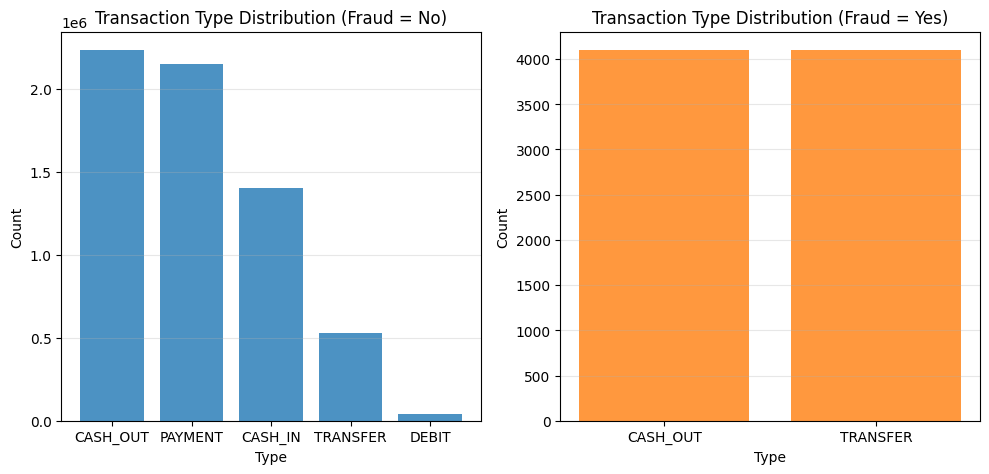

In [180]:
# Transaction type distribution: faceted by fraud status
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

fraud_no = df[df['isFraud'] == 0]['type'].value_counts()
fraud_yes = df[df['isFraud'] == 1]['type'].value_counts()

axes[0].bar(fraud_no.index, fraud_no.values, color='C0', alpha=0.8)
axes[0].set_title('Transaction Type Distribution (Fraud = No)')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(fraud_yes.index, fraud_yes.values, color='C1', alpha=0.8)
axes[1].set_title('Transaction Type Distribution (Fraud = Yes)')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Count')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [181]:
# Correlation between amount and isFraud
correlation = df['amount'].corr(df['isFraud'])
print(f"Pearson Correlation (amount vs isFraud): {correlation:.4f}")

# Additional statistics
print(f"\nMean amount (Non-Fraud): {df[df['isFraud']==0]['amount'].mean():.2f}")
print(f"Mean amount (Fraud): {df[df['isFraud']==1]['amount'].mean():.2f}")
print(f"Median amount (Non-Fraud): {df[df['isFraud']==0]['amount'].median():.2f}")
print(f"Median amount (Fraud): {df[df['isFraud']==1]['amount'].median():.2f}")

Pearson Correlation (amount vs isFraud): 0.0768

Mean amount (Non-Fraud): 178197.04
Mean amount (Fraud): 1470832.67

Mean amount (Non-Fraud): 178197.04
Mean amount (Fraud): 1470832.67
Median amount (Non-Fraud): 74684.72
Median amount (Fraud): 442290.23
Median amount (Non-Fraud): 74684.72
Median amount (Fraud): 442290.23


In [182]:
# 1. Point-biserial correlation (better than Pearson for binary targets)
from scipy.stats import pointbiserialr
corr, pval = pointbiserialr(df['isFraud'], df['amount'])
print(f"Point-biserial correlation: {corr:.4f}, p-value: {pval}")

# 2. Mutual Information (captures non-linear relationships)
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(df[['amount']].values, df['isFraud'].values, random_state=42)
print(f"Mutual Information: {mi[0]:.4f}")

# 3. AUC-ROC (focuses on ranking, not accuracy; immune to class imbalance)
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
amount_scaled = scaler.fit_transform(df[['amount']])
auc = roc_auc_score(df['isFraud'], amount_scaled)
print(f"AUC-ROC (using amount as predictor): {auc:.4f}")

# 4. Effect size (Cohen's d) - standardized mean difference
fraud_mean = df[df['isFraud']==1]['amount'].mean()
nonfraud_mean = df[df['isFraud']==0]['amount'].mean()
fraud_std = df[df['isFraud']==1]['amount'].std()
nonfraud_std = df[df['isFraud']==0]['amount'].std()
pooled_std = ((fraud_std**2 + nonfraud_std**2) / 2) ** 0.5
cohens_d = (fraud_mean - nonfraud_mean) / pooled_std
print(f"Cohen's d: {cohens_d:.4f}")

# 5. Statistical significance test (Mann-Whitney U for non-normal data)
from scipy.stats import mannwhitneyu
stat, pval_mw = mannwhitneyu(df[df['isFraud']==1]['amount'], 
                               df[df['isFraud']==0]['amount'], 
                               alternative='two-sided')
print(f"Mann-Whitney U test p-value: {pval_mw}")

Point-biserial correlation: 0.0768, p-value: 0.0
Mutual Information: 0.0024
Mutual Information: 0.0024
AUC-ROC (using amount as predictor): 0.7915
AUC-ROC (using amount as predictor): 0.7915
Cohen's d: 0.7376
Cohen's d: 0.7376
Mann-Whitney U test p-value: 0.0
Mann-Whitney U test p-value: 0.0


# Cleaning

In [183]:
df['step'] = df['step']//30

C:\Users\User\AppData\Local\Temp\ipykernel_5980\1955420131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step'] = df['step']//30


In [184]:
df.rename(columns={'step':'hour'}, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_5980\2087823912.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'step':'hour'}, inplace=True)


In [186]:
never_fraud = ['DEBIT', 'CASH_IN', 'PAYMENT']

df['type'] = df['type'].apply(lambda x: 'Other' if x in never_fraud else x)

df['type'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_5980\2021652865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['type'].apply(lambda x: 'Other' if x in never_fraud else x)


type
Other       3592211
CASH_OUT    2237484
TRANSFER     532909
Name: count, dtype: int64

In [187]:
df

,hour,type,amount,nameOrig,nameDest,isFraud
0,0,Other,9839.64,C1231006815,M1979787155,0
1,0,Other,1864.28,C1666544295,M2044282225,0
2,0,TRANSFER,181.00,C1305486145,C553264065,1
3,0,CASH_OUT,181.00,C840083671,C38997010,1
4,0,Other,11668.14,C2048537720,M1230701703,0
...,...,...,...,...,...,...
6362615,24,CASH_OUT,339682.13,C786484425,C776919290,1
6362616,24,TRANSFER,6311409.28,C1529008245,C1881841831,1
6362617,24,CASH_OUT,6311409.28,C1162922333,C1365125890,1
6362618,24,TRANSFER,850002.52,C1685995037,C2080388513,1


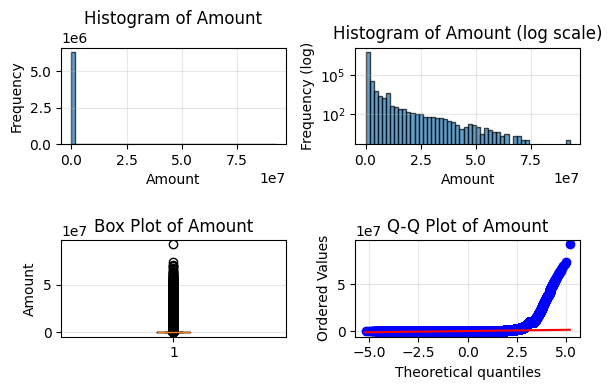

Skewness: 30.9939
Kurtosis: 1797.9515

Interpretation:
  Skewness > 0: Right-skewed (tail extends to the right)
  Skewness < 0: Left-skewed (tail extends to the left)
  |Skewness| < 0.5: Approximately symmetric


In [189]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(6, 4))

# Histogram
axes[0, 0].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Histogram of Amount')
axes[0, 0].set_xlabel('Amount')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# Log-scale histogram (to see if it helps)
axes[0, 1].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Histogram of Amount (log scale)')
axes[0, 1].set_xlabel('Amount')
axes[0, 1].set_ylabel('Frequency (log)')
axes[0, 1].grid(True, alpha=0.3)

# Box plot
axes[1, 0].boxplot(df['amount'], vert=True)
axes[1, 0].set_title('Box Plot of Amount')
axes[1, 0].set_ylabel('Amount')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Q-Q plot (to assess normality)
from scipy import stats
stats.probplot(df['amount'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Amount')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print skewness and kurtosis
from scipy.stats import skew, kurtosis
print(f"Skewness: {skew(df['amount']):.4f}")
print(f"Kurtosis: {kurtosis(df['amount']):.4f}")
print(f"\nInterpretation:")
print(f"  Skewness > 0: Right-skewed (tail extends to the right)")
print(f"  Skewness < 0: Left-skewed (tail extends to the left)")
print(f"  |Skewness| < 0.5: Approximately symmetric")

#### We conclude this column 'amount' is heavily polluted with outliers. However due to this being such a large indicator of whether a transaction is fraudulent or not, I will leave it as is.

#### Many more features can surely be made, such as tracking pairs of Destination and Origins as well as periods between these transactions but we must take into account that this could leak future data. So first, we split:

# Splitting

In [191]:
y = df['isFraud']
X = df.drop(columns=['isFraud'])

In [192]:
X

,hour,type,amount,nameOrig,nameDest
0,0,Other,9839.64,C1231006815,M1979787155
1,0,Other,1864.28,C1666544295,M2044282225
2,0,TRANSFER,181.00,C1305486145,C553264065
3,0,CASH_OUT,181.00,C840083671,C38997010
4,0,Other,11668.14,C2048537720,M1230701703
...,...,...,...,...,...
6362615,24,CASH_OUT,339682.13,C786484425,C776919290
6362616,24,TRANSFER,6311409.28,C1529008245,C1881841831
6362617,24,CASH_OUT,6311409.28,C1162922333,C1365125890
6362618,24,TRANSFER,850002.52,C1685995037,C2080388513


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temporary, y_train, y_temporary = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_val, y_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
